# PDE solver using Deep Learning

Heat equation: 
$$\partial_t u(t,x) + k \cdot tr(\partial_{xx} u(t,x)) = 0, \quad (t,x)\in [0,T]\times \Omega$$
$$u(T,x) = g(x)$$



In [10]:
%matplotlib inline  
import torch
import torch.nn as nn
import math
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt


We define the DGM layer as in https://arxiv.org/pdf/1708.07469.pdf

In [11]:
class DGM_Layer(nn.Module):
    
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()
        
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))
            

        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)
            
    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l
    
    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)
        
        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)
        
        output = ((1-G))*H + Z*S
        return output

We define the whole network by combining threee DGM layers

In [12]:
class Net_DGM(nn.Module):
    
    def __init__(self, dim_x, dim_S, activation='Sigmoid'):
        super(Net_DGM, self).__init__()
        
        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation)
        
        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        
        self.output_layer = nn.Linear(dim_S, dim_x)
    
    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output

Automatic Differentiation in order to obtain gradient and trace of Hessian of a network in terms of its inputs

In [13]:
def get_gradient(output, x):
    grad = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True, retain_graph=True, only_inputs=True)[0]
    return grad

def get_laplacian(grad, x):
    hess_diag = []
    for d in range(x.shape[1]):
        v = grad[:,d].view(-1,1)
        grad2 = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hess_diag.append(grad2[:,d].view(-1,1))    
    hess_diag = torch.cat(hess_diag,1)
    laplacian = hess_diag.sum(1, keepdim=True)
    return laplacian


Terminal condition

In [14]:
def g(x):
    output = 10*torch.exp(-torch.norm(x,2,1)**2/(2*0.1**2))
    return output


We define the network, the type of optimizer (Adam), and the loss function (MSE to approximate integral by Monte Carlo Integration).

In [15]:
model = Net_DGM(dim_x=1, dim_S=5, activation="Tanh")
k = 0.5

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

n_iter = 100 # to be changed
batch_size = 5000
dim = 1 

We train the network

In [16]:
for it in range(n_iter):
    optimizer.zero_grad()
    
    input_domain = torch.randn(batch_size, dim, requires_grad=True)*math.sqrt(5) # x is uniformly sampled in [0,1]^d. Change this if domain changes
    t = torch.rand(batch_size, 1, requires_grad=True)
    #input_domain.requires_grad = True
    #t.requires_grad = True
    #init_time_forward = time.time()
    u_of_tx = model(t, input_domain)
    grad_u_x = get_gradient(u_of_tx,input_domain)
    grad_u_t = get_gradient(u_of_tx, t)
    laplacian = get_laplacian(grad_u_x, input_domain)
    target_functional = torch.zeros_like(u_of_tx)
    MSE_functional = loss_fn(grad_u_t + k * laplacian, target_functional)
    
    input_terminal = torch.randn(batch_size, dim)*math.sqrt(5)
    t = torch.ones(batch_size, 1)
    u_of_tx = model(t, input_terminal)
    target_terminal = g(input_terminal)
    MSE_terminal = loss_fn(u_of_tx, target_terminal.view(-1,1))
    
    loss = MSE_functional + MSE_terminal
    loss.backward()
    optimizer.step()
    
    if it%10 == 0:
        print("Iteration: {}/{}\t MSE functional: {:.4f}\t MSE terminal: {:.4f}\t Total Loss: {:.4f}\n".format(it, n_iter, MSE_functional.item(), MSE_terminal.item(), loss.item()))
        

Iteration: 0/100	 MSE functional: 0.0288	 MSE terminal: 4.3003	 Total Loss: 4.3291

Iteration: 10/100	 MSE functional: 0.0152	 MSE terminal: 3.8359	 Total Loss: 3.8511

Iteration: 20/100	 MSE functional: 0.0086	 MSE terminal: 3.7641	 Total Loss: 3.7727

Iteration: 30/100	 MSE functional: 0.0067	 MSE terminal: 3.3790	 Total Loss: 3.3857

Iteration: 40/100	 MSE functional: 0.0068	 MSE terminal: 3.1887	 Total Loss: 3.1955

Iteration: 50/100	 MSE functional: 0.0082	 MSE terminal: 3.2926	 Total Loss: 3.3008

Iteration: 60/100	 MSE functional: 0.0094	 MSE terminal: 3.2722	 Total Loss: 3.2815

Iteration: 70/100	 MSE functional: 0.0106	 MSE terminal: 3.6515	 Total Loss: 3.6621

Iteration: 80/100	 MSE functional: 0.0133	 MSE terminal: 3.1080	 Total Loss: 3.1212

Iteration: 90/100	 MSE functional: 0.0171	 MSE terminal: 2.9398	 Total Loss: 2.9569



I load a model that I had pre-trained. Execute the below cell only if you want to load a model

In [17]:
path = "/Users/msabate/Projects/Seminars/src" # change this
state = torch.load(path+"/DGM_Heat_equation.pth.tar")
model.load_state_dict(state["state"])

Analytical solution to compare with the network

In [18]:
T = 1.0; # the terminal time in the PDE
def Phi(t: float, x : np.array):
    d = x.shape[0]
    normalizing_const = 1.0/((2*np.pi*(T-t))**(0.5*d))
    return normalizing_const*np.exp(-np.dot(x,x)/(2*(T-t)))

# x represents a point in R^d
def terminal_g(x : np.array):
    norm_x_squared = np.dot(x,x)
    g = 10.0*np.exp(-norm_x_squared/(2*0.1**2))
    return g

def integrand1d(y0: float, t: float, x: np.array):
    y = np.array([y0])
    return Phi(t,x-y)*terminal_g(y)

def heat_eq_1d(t: float, x : float):
    return integrate.quad(integrand1d, -5, 5,args=(t,x))[0]

heat_eq_1d_vec = np.vectorize(heat_eq_1d, excluded=['t'])

Plots

0


No handles with labels found to put in legend.


1


No handles with labels found to put in legend.


2


No handles with labels found to put in legend.


3


No handles with labels found to put in legend.


4


No handles with labels found to put in legend.


5


No handles with labels found to put in legend.


6


No handles with labels found to put in legend.


7


No handles with labels found to put in legend.


8


No handles with labels found to put in legend.


9


No handles with labels found to put in legend.


10


No handles with labels found to put in legend.


11


No handles with labels found to put in legend.


12


No handles with labels found to put in legend.


13


No handles with labels found to put in legend.


14


No handles with labels found to put in legend.


15


No handles with labels found to put in legend.


16


No handles with labels found to put in legend.


17


No handles with labels found to put in legend.


18


No handles with labels found to put in legend.


19


No handles with labels found to put in legend.


20


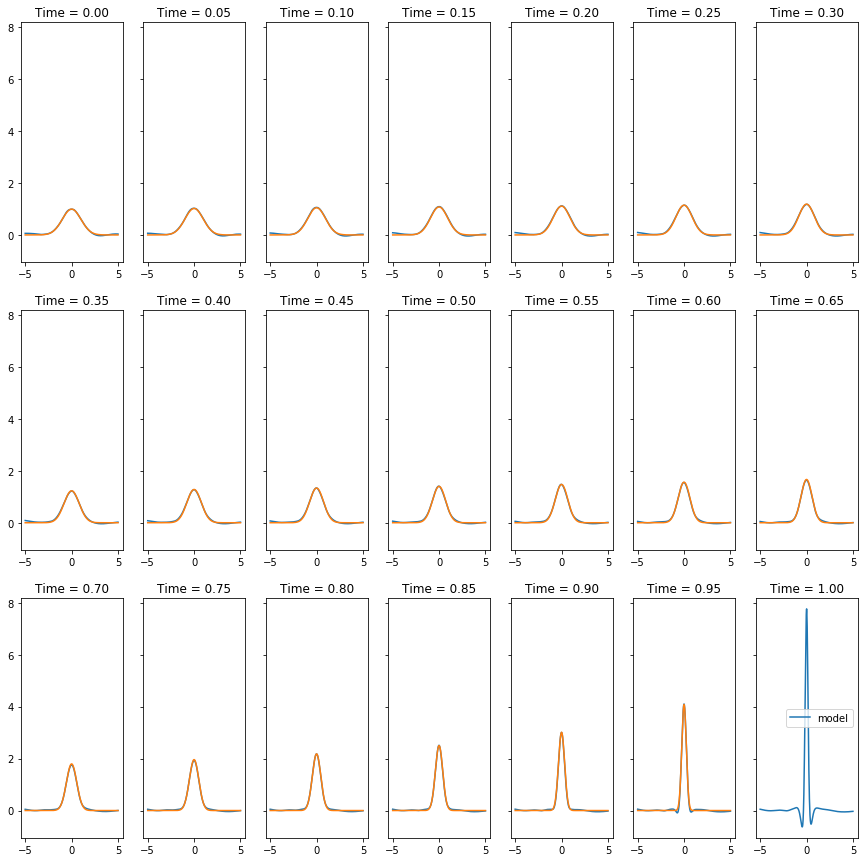

In [19]:
x_vals = np.linspace(-5,5,500)
x = torch.tensor(x_vals, dtype=torch.float).view(-1,1)
x.requires_grad=True
fig, ax = plt.subplots(nrows=3,ncols=7, sharey=True, figsize=(15,15))

timegrid = np.linspace(0,1,21)
for i in range(len(timegrid)):
    print(i)
    row = i//7
    col = i%7
    t = torch.ones_like(x)*timegrid[i]
    v = model(t,x)
    
    ax[row,col].plot(x.data.numpy(),v.data.numpy(),label="model")
    if i<len(timegrid)-1:
        t = timegrid[i]
        v_vals = heat_eq_1d_vec(t,x_vals);
        ax[row,col].plot(x_vals,v_vals,label="benchmark")
    plt.legend()
    ax[row,col].set_title('Time = {:.2f}'.format(timegrid[i]))